# When To Stop Fuzzing

In the past chapters, we have discussed several fuzzing techniques.  Knowing _what_ to do is important, but it is also important to know when to _stop_ doing things.  In this chapter, we will learn when to _stop fuzzing_ – and use a prominent example for this purpose: The *Enigma* machine that was used in the second world war by the navy of Nazi Germany to encrypt communications, and how Alan Turing and I.J. Good used _fuzzing techniques_ to crack ciphers for the Naval Enigma machine.

Turing did not only develop the foundations of computer science, the Turing machine. Together with his assistant I.J. Good, he also invented estimators of the probability of an event occuring that has never previously occured. We show how the Good-Turing estimator can be used to quantify the *residual risk* of a fuzzing campaign that finds no vulnerabilities. Meaning, we show how it estimates the probability of discovering a vulnerability when no vulnerability has been observed before throughout the fuzzing campaign.

We discuss means to speed up [coverage-based fuzzers](Coverage.ipynb) and introduce a range of estimation and extrapolation methodologies to assess and extrapolate fuzzing progress and residual risk.

**Prerequisites**

* _The chapter on [Coverage](Coverage.ipynb) discusses how to use coverage information for an executed test input to guide a coverage-based mutational greybox fuzzer_.
* Some knowledge of statistics is helpful.

In [1]:
import bookutils

In [2]:
import Fuzzer
import Coverage

## The Enigma Machine

It is autumn in the year of 1938. Turing has just finished his PhD at Princeton University demonstrating the limits of computation and laying the foundation for the theory of computer science. Nazi Germany is rearming. It has reoccupied the Rhineland and annexed Austria against the treaty of Versailles. It has just annexed the Sudetenland in Czechoslovakia and begins preparations to take over the rest of Czechoslovakia despite an agreement just signed in Munich.

Meanwhile, the British intelligence is building up their capability to break encrypted messages used by the Germans to communicate military and naval information. The Germans are using [Enigma machines](https://en.wikipedia.org/wiki/Enigma_machine) for encryption.  Enigma machines use a series of electro-mechanical rotor cipher machines to protect military communication.  Here is a picture of an Enigma machine:

![Enigma Machine](PICS/Bletchley_Park_Naval_Enigma_IMG_3604.JPG)

By the time Turing joined the British Bletchley park, the Polish intelligence reverse engineered the logical structure of the Enigma machine and built a decryption machine called *Bomba* (perhaps because of the ticking noise they made). A bomba simulates six Enigma machines simultaneously and tries different decryption keys until the code is broken. The Polish bomba might have been the very _first fuzzer_.

Turing took it upon himself to crack ciphers of the Naval Enigma machine, which were notoriously hard to crack. The Naval Enigma used, as part of its encryption key, a three letter sequence called *trigram*. These trigrams were selected from a book, called *Kenngruppenbuch*, which contained all trigrams in a random order.

### The Kenngruppenbuch

Let's start with the Kenngruppenbuch (K-Book).

We are going to use the following Python functions.
* `shuffle(elements)` - shuffle *elements* and put items in random order.
* `choice(elements, p=weights)` - choose an item from *elements* at random. An element with twice the *weight* is twice as likely to be chosen.
* `log(a)` - returns the natural logarithm of a.
* `a ** b` - means `a` to the power of `b` (a.k.a. [power operator](https://docs.python.org/3/reference/expressions.html#the-power-operator))

In [3]:
import string

In [4]:
import numpy
from numpy.random import choice
from numpy.random import shuffle
from numpy import log

We start with creating the set of trigrams:

In [5]:
letters = list(string.ascii_letters[26:])  # upper-case characters
trigrams = [str(a + b + c) for a in letters for b in letters for c in letters]
shuffle(trigrams)

In [6]:
trigrams[:10]

['FIW', 'LIO', 'IQA', 'HJP', 'RGB', 'SLM', 'EYW', 'VVX', 'TUK', 'YLJ']

These now go into the Kenngruppenbuch.  However, it was observed that some trigrams were more likely chosen than others. For instance, trigrams at the top-left corner of any page, or trigrams on the first or last few pages were more likely than one somewhere in the middle of the book or page.  We reflect this difference in distribution by assigning a _probability_ to each trigram, using Benford's law as introduced in [Probabilistic Fuzzing](ProbabilisticGrammarFuzzer.ipynb).

Recall, that Benford's law assigns the $i$-th digit the probability $\log_{10}\left(1 + \frac{1}{i}\right)$ where the base 10 is chosen because there are 10 digits $i\in [0,9]$. However, Benford's law works for an arbitrary number of "digits". Hence, we assign the $i$-th trigram the probability $\log_b\left(1 + \frac{1}{i}\right)$ where the base $b$ is the number of all possible trigrams $b=26^3$. 

In [7]:
k_book = {}  # Kenngruppenbuch

for i in range(1, len(trigrams) + 1):
    trigram = trigrams[i - 1]
    # choose weights according to Benford's law
    k_book[trigram] = log(1 + 1 / i) / log(26**3 + 1)

Here's a random trigram from the Kenngruppenbuch:

In [8]:
random_trigram = choice(list(k_book.keys()), p=list(k_book.values()))
random_trigram

'MHA'

And this is its probability:

In [9]:
k_book[random_trigram]

0.006602847677166207

### Fuzzing the Enigma

In the following, we introduce an extremely simplified implementation of the Naval Enigma based on the trigrams from the K-book. Of course, the encryption mechanism of the actual Enigma machine is much more sophisticated and worthy of a much more detailed investigation. We encourage the interested reader to follow up with further reading listed in the Background section.

The personell at Bletchley Park can only check whether an encoded message is encoded with a (guessed) trigram.
Our implementation `naval_enigma()` takes a `message` and a `key` (i.e., the guessed trigram).  If the given key matches the (previously computed) key for the message, `naval_enigma()` returns `True`.

In [10]:
from Fuzzer import RandomFuzzer
from Fuzzer import Runner

In [11]:
class EnigmaMachine(Runner):
    def __init__(self, k_book):
        self.k_book = k_book
        self.reset()

    def reset(self):
        """Resets the key register"""
        self.msg2key = {}
        
    def internal_msg2key(self, message):
        """Internal helper method. 
           Returns the trigram for an encoded message."""
        if not message in self.msg2key:
            # Simulating how an officer chooses a key from the Kenngruppenbuch to encode the message.
            self.msg2key[message] = choice(list(self.k_book.keys()), p=list(self.k_book.values()))
        trigram = self.msg2key[message]
        return trigram

    def naval_enigma(self, message, key):
        """Returns true if 'message' is encoded with 'key'"""
        if key == self.internal_msg2key(message):
            return True
        else:
            return False

To "fuzz" the `naval_enigma()`, our job will be to come up with a key that matches a given (encrypted) message.  Since the keys only have three characters, we have a good chance to achieve this in much less than a second.  (Of course, longer keys will be much harder to find via random fuzzing.)

In [12]:
class EnigmaMachine(EnigmaMachine):
    def run(self, tri):
        """PASS if cur_msg is encoded with trigram tri"""
        if self.naval_enigma(self.cur_msg, tri):
            outcome = self.PASS
        else:
            outcome = self.FAIL

        return (tri, outcome)

Now we can use the `EnigmaMachine` to check whether a certain message is encoded with a certain trigram.

In [13]:
enigma = EnigmaMachine(k_book)
enigma.cur_msg = "BrEaK mE. L0Lzz"
enigma.run("AAA")

('AAA', 'FAIL')

The simplest way to crack an encoded message is by brute forcing. Suppose, at Bletchley park they would try random trigrams until a message is broken.

In [14]:
class BletchleyPark(object):
    def __init__(self, enigma):
        self.enigma = enigma
        self.enigma.reset()
        self.enigma_fuzzer = RandomFuzzer(
            min_length=3,
            max_length=3,
            char_start=65,
            char_range=26)
        
    def break_message(self, message):
        """Returning the trigram for an encoded message"""
        self.enigma.cur_msg = message
        while True:
            (trigram, outcome) = self.enigma_fuzzer.run(self.enigma)
            if outcome == self.enigma.PASS:
                break
        return trigram

How long does it take Bletchley park to find the key using this brute forcing approach?

In [15]:
from Timer import Timer

In [16]:
enigma = EnigmaMachine(k_book)
bletchley = BletchleyPark(enigma)

with Timer() as t:
    trigram = bletchley.break_message("BrEaK mE. L0Lzz")

Here's the key for the current message:

In [17]:
trigram

'HBH'

And no, this did not take long:

In [18]:
'%f seconds' % t.elapsed_time()

'0.030324 seconds'

In [19]:
'Bletchley cracks about %d messages per second' % (1/t.elapsed_time())

'Bletchley cracks about 32 messages per second'

### Turing's Observations
Okay, lets crack a few messages and count the number of times each trigram is observed.

In [20]:
from collections import defaultdict

In [21]:
n = 100  # messages to crack

In [22]:
observed = defaultdict(int)
for msg in range(0, n):
    trigram = bletchley.break_message(msg)
    observed[trigram] += 1

# list of trigrams that have been observed
counts = [k for k, v in observed.items() if int(v) > 0]

t_trigrams = len(k_book)
o_trigrams = len(counts)

In [23]:
"After cracking %d messages, we observed %d out of %d trigrams." % (
    n, o_trigrams, t_trigrams)

'After cracking 100 messages, we observed 87 out of 17576 trigrams.'

In [24]:
singletons = len([k for k, v in observed.items() if int(v) == 1])

In [25]:
"From the %d observed trigrams, %d were observed only once." % (
    o_trigrams, singletons)

'From the 87 observed trigrams, 78 were observed only once.'

Given a sample of previously used entries, Turing wanted to _estimate the likelihood_ that the current unknown entry was one that had been previously used, and further, to estimate the probability distribution over the previously used entries. This lead to the development of the estimators of the missing mass and estimates of the true probability mass of the set of items occuring in the sample. Good worked with Turing during the war and, with Turing’s permission, published the analysis of the bias of these estimators in 1953.

Suppose, after finding the keys for n=100 messages, we have observed the trigram "ABC" exactly $X_\text{ABC}=10$ times. What is the probability $p_\text{ABC}$ that "ABC" is the key for the next message? Empirically, we would estimate $\hat p_\text{ABC}=\frac{X_\text{ABC}}{n}=0.1$. We can derive the empirical estimates for all other trigrams that we have observed.  However, it becomes quickly evident that the complete probability mass is distributed over the *observed* trigrams. This leaves no mass for *unobserved* trigrams, i.e., the probability of discovering a new trigram. This is called the missing probability mass or the discovery probability.

Turing and Good derived an estimate of the *discovery probability* $p_0$, i.e., the probability to discover an unobserved trigram, as the number $f_1$ of trigrams observed exactly once divided by the total number $n$ of messages cracked:
$$
p_0 = \frac{f_1}{n}
$$
where $f_1$ is the number of singletons and $n$ is the number of cracked messages.

Lets explore this idea for a bit. We'll extend `BletchleyPark` to crack `n` messages and record the number of trigrams observed as the number of cracked messages increases.

In [26]:
class BletchleyPark(BletchleyPark):
    
    
    def break_message(self, message):
        """Returning the trigram for an encoded message"""
        # For the following experiment, we want to make it practical
        #   to break a large number of messages. So, we remove the
        #   loop and just return the trigram for a message.
        #
        # enigma.cur_msg = message
        # while True:
        #     (trigram, outcome) = self.enigma_fuzzer.run(self.enigma)
        #     if outcome == self.enigma.PASS:
        #         break
        trigram = enigma.internal_msg2key(message)
        return trigram
    
    def break_n_messages(self, n):
        """Returns how often each trigram has been observed, 
           and #trigrams discovered for each message."""
        observed = defaultdict(int)
        timeseries = [0] * n

        # Crack n messages and record #trigrams observed as #messages increases
        cur_observed = 0
        for cur_msg in range(0, n):
            trigram = self.break_message(cur_msg)
            
            observed[trigram] += 1
            if (observed[trigram] == 1):
                cur_observed += 1
            timeseries[cur_msg] = cur_observed
            
        return (observed, timeseries)

Let's crack 2000 messages and compute the GT-estimate.

In [27]:
n = 2000        # messages to crack

In [28]:
bletchley = BletchleyPark(enigma)
(observed, timeseries) = bletchley.break_n_messages(n)

Let us determine the Good-Turing estimate of the probability that the next trigram has not been observed before:

In [29]:
singletons = len([k for k, v in observed.items() if int(v) == 1])
gt = singletons / n
gt

0.377

We can verify the Good-Turing estimate empirically and compute the empirically determined probability that the next trigram has not been observed before. To do this, we repeat the following experiment `repeats=1000` times, reporting the average: If the next message is a new trigram, return 1, otherwise return 0. Note that here, we do not record the newly discovered trigrams as observed.

In [30]:
repeats = 1000  # experiment repetitions    

In [31]:
newly_discovered = 0
for cur_msg in range(n, n + repeats):
    trigram = bletchley.break_message(cur_msg)
    if(observed[trigram] == 0):
        newly_discovered += 1
        
newly_discovered / repeats

0.411

Looks pretty accurate, huh? The difference between estimates is reasonably small, probably below 0.03. However, the Good-Turing estimate did not nearly require as much computational resources as the empirical estimate. Unlike the empirical estimate, the Good-Turing estimate can be computed during the campaign. Unlike the empirical estimate, the Good-Turing estimate requires no additional, redundant repetitions.

In fact, the Good-Turing (GT) estimator often performs close to the best estimator for arbitrary distributions ([Try it here!](#Kenngruppenbuch)). Of course, the concept of *discovery* is not limited to trigrams. The GT estimator is also used in the study of natural languages to estimate the likelihood that we haven't ever heard or read the word we next encounter. The GT estimator is used in ecology to estimate the likelihood of discovering a new, unseen species in our quest to catalog all _species_ on earth. Later, we will see how it can be used to estimate the probability to discover a vulnerability when none has been observed, yet (i.e., residual risk).

Alan Turing was interested in the _complement_ $(1-GT)$ which gives the proportion of _all_ messages for which the Brits have already observed the trigram needed for decryption. For this reason, the complement is also called sample coverage. The *sample coverage* quantifies how much we know about decryption of all messages given the few messages we have already decrypted. 

The probability that the next message can be decrypted with a previously discovered trigram is:

In [32]:
1 - gt

0.623

The *inverse* of the GT-estimate (1/GT) is a _maximum likelihood estimate_ of the expected number of messages that we can decrypt with previously observed trigrams before having to find a new trigram to decrypt the message.  In our setting, the number of messages for which we can expect to reuse previous trigrams before having to discover a new trigram is:

In [33]:
1 / gt

2.6525198938992043

But why is GT so accurate? Intuitively, despite a large sampling effort (i.e., cracking $n$ messages), there are still $f_1$ trigrams that have been observed only once. We could say that such "singletons" are very rare trigrams. Hence, the probability that the next messages is encoded with such a rare but observed trigram gives a good upper bound on the probability that the next message is encoded with an evidently much rarer, unobserved trigram. Since Turing's observation 80 years ago, an entire statistical theory has been developed around the hypothesis that rare, observed "species" are good predictors of unobserved species.

Let's have a look at the distribution of rare trigrams.

In [34]:
%matplotlib inline

In [35]:
import matplotlib.pyplot as plt

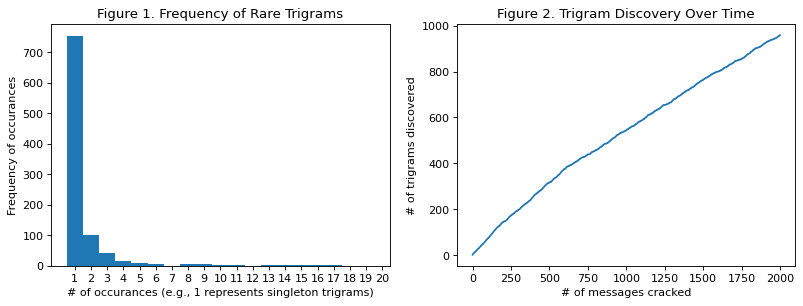

In [36]:
frequencies = [v for k, v in observed.items() if int(v) > 0]
frequencies.sort(reverse=True)
# Uncomment to see how often each discovered trigram has been observed
# print(frequencies)

# frequency of rare trigrams
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.hist(frequencies, range=[1, 21], bins=numpy.arange(1, 21) - 0.5)
plt.xticks(range(1, 21))
plt.xlabel('# of occurances (e.g., 1 represents singleton trigrams)')
plt.ylabel('Frequency of occurances')
plt.title('Figure 1. Frequency of Rare Trigrams')

# trigram discovery over time
plt.subplot(1, 2, 2)
plt.plot(timeseries)
plt.xlabel('# of messages cracked')
plt.ylabel('# of trigrams discovered')
plt.title('Figure 2. Trigram Discovery Over Time');

In [37]:
# Statistics for most and least often observed trigrams
singletons = len([v for k, v in observed.items() if int(v) == 1])
total = len(frequencies)

print("%3d of %3d trigrams (%.3f%%) have been observed   1 time (i.e., are singleton trigrams)."
      % (singletons, total, singletons * 100 / total))

print("%3d of %3d trigrams ( %.3f%%) have been observed %d times."
      % (1, total, 1 / total, frequencies[0]))

754 of 959 trigrams (78.624%) have been observed   1 time (i.e., are singleton trigrams).
  1 of 959 trigrams ( 0.001%) have been observed 153 times.


The *majority of trigrams* have been observed only once, as we can see in Figure 1 (left). In other words, the majority of observed trigrams are "rare" singletons. In Figure 2 (right), we can see that discovery is in full swing. The trajectory seems almost linear. However, since there is a finite number of trigrams (26^3 = 17,576) trigram discovery will slow down and eventually approach an asymptote (the total number of trigrams).

### Boosting the Performance of BletchleyPark
Some trigrams have been observed very often. We call these "abundant" trigrams.

In [38]:
print("Trigram : Frequency")
for trigram in sorted(observed, key=observed.get, reverse=True):
    if observed[trigram] > 10:
        print("    %s : %d" % (trigram, observed[trigram]))

Trigram : Frequency
    FIW : 153
    LIO : 82
    IQA : 66
    RGB : 42
    HJP : 41
    VVX : 40
    SLM : 37
    TUK : 26
    XIT : 21
    CSB : 20
    BTS : 17
    YLJ : 17
    MHA : 16
    EYW : 16
    MQM : 15
    ZCL : 14
    QKX : 13
    RWE : 11
    ZUJ : 11
    LQB : 11


We'll speed up the code breaking by _trying the abundant trigrams first_. 

First, we'll find out how many messages can be cracked by the existing brute forcing strategy at Bledgley park, given a maximum number of attempts. We'll also track the number of messages cracked over time (`timeseries`).

In [39]:
class BletchleyPark(BletchleyPark):
    
    def __init__(self, enigma):
        super().__init__(enigma)
        self.cur_attempts = 0
        self.cur_observed = 0
        self.observed = defaultdict(int)
        self.timeseries = [None] * max_attempts * 2
    
    def break_message(self, message):
        """Returns the trigram for an encoded message, and
           track #trigrams observed as #attempts increases."""
        self.enigma.cur_msg = message
        while True:
            self.cur_attempts += 1                                 # NEW
            (trigram, outcome) = self.enigma_fuzzer.run(self.enigma)
            self.timeseries[self.cur_attempts] = self.cur_observed # NEW
            if outcome == self.enigma.PASS: 
                break
        return trigram
    
    def break_max_attempts(self, max_attempts):
        """Returns #messages successfully cracked after a given #attempts."""
        cur_msg  = 0
        n_messages = 0

        while True:
            trigram = self.break_message(cur_msg)
            
            # stop when reaching max_attempts
            if self.cur_attempts >= max_attempts:
                break
                
            # update observed trigrams
            n_messages += 1
            self.observed[trigram] += 1
            if (self.observed[trigram] == 1):
                self.cur_observed += 1
                self.timeseries[self.cur_attempts] = self.cur_observed
            cur_msg += 1
        return n_messages

`original` is the number of messages cracked by the bruteforcing strategy, given 100k attempts.  Can we beat this?

In [40]:
max_attempts = 100000

In [41]:
bletchley = BletchleyPark(enigma)
original = bletchley.break_max_attempts(max_attempts)
original

3

Now, we'll create a boosting strategy by trying trigrams first that we have previously observed most often.

In [42]:
class BoostedBletchleyPark(BletchleyPark):
    
    def break_message(self, message):
        """Returns the trigram for an encoded message, and
           track #trigrams observed as #attempts increases."""
        self.enigma.cur_msg = message
        
        # boost cracking by trying observed trigrams first
        for trigram in sorted(self.prior, key=self.prior.get, reverse=True):
            self.cur_attempts += 1
            (_, outcome) = self.enigma.run(trigram)
            self.timeseries[self.cur_attempts] = self.cur_observed
            if outcome == self.enigma.PASS:
                return trigram
            
        # else fall back to normal cracking
        return super().break_message(message)

`boosted` is the number of messages cracked by the boosted strategy.

In [43]:
boostedBletchley = BoostedBletchleyPark(enigma)
boostedBletchley.prior = observed
boosted = boostedBletchley.break_max_attempts(max_attempts)
boosted

1

We see that the boosted technique cracks substantially more messages. It is worthwhile to record how often each trigram is being used as key and try them in the order of their occurence.

***Try it***. *For practical reasons, we use a large number of previous observations as prior (`boostedBletchley.prior = observed`). You can try to  change the code such that the strategy uses the trigram frequencies (`self.observed`) observed **during** the campaign itself to boost the campaign. You will need to increase `max_attempts` and wait for a long while.*

Let's compare the number of trigrams discovered over time.

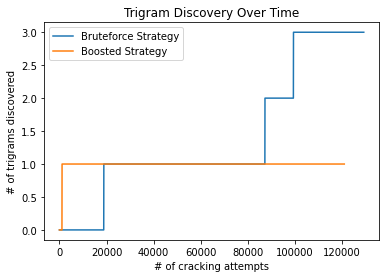

In [44]:
# print plots
line_old, = plt.plot(bletchley.timeseries, label="Bruteforce Strategy")
line_new, = plt.plot(boostedBletchley.timeseries, label="Boosted Strategy")
plt.legend(handles=[line_old, line_new])
plt.xlabel('# of cracking attempts')
plt.ylabel('# of trigrams discovered')
plt.title('Trigram Discovery Over Time');

We see that the boosted fuzzer is constantly superior over the random fuzzer.

## Estimating the Probability of Path Discovery

<!-- ## Residual Risk: Probability of Failure after an Unsuccessful Fuzzing Campaign -->
<!-- Residual risk is not formally defined in this section, so I made the title a bit more generic -- AZ -->

So, what does Turing's observation for the Naval Enigma have to do with fuzzing _arbitrary_ programs? Turing's assistant I.J. Good extended and published Turing's work on the estimation procedures in Biometrica, a journal for theoretical biostatistics that still exists today. Good did not talk about trigrams. Instead, he calls them "species". Hence, the GT estimator is presented to estimate how likely it is to discover a new species, given an existing sample of individuals (each of which belongs to exactly one species). 

Now, we can associate program inputs to species, as well. For instance, we could define the path that is exercised by an input as that input's species. This would allow us to _estimate the probability that fuzzing discovers a new path._ Later, we will see how this discovery probability estimate also estimates the likelihood of discovering a vulnerability when we have not seen one, yet (residual risk).

Let's do this. We identify the species for an input by computing a hash-id over the set of statements exercised by that input. In the [Coverage](Coverage.ipynb) chapter, we have learned about the [Coverage class](Coverage.ipynb#A-Coverage-Class) which collects coverage information for an executed Python function. As an example, the function [`cgi_decode()`](Coverage.ipynb#A-CGI-Decoder) was introduced. The function `cgi_decode()` takes a string encoded for a website URL and decodes it back to its original form.

Here's what `cgi_decode()` does and how coverage is computed.

In [45]:
from Coverage import Coverage, cgi_decode

In [46]:
encoded = "Hello%2c+world%21"
with Coverage() as cov:
    decoded = cgi_decode(encoded)

In [47]:
decoded

'Hello, world!'

In [48]:
print(cov.coverage());

{('cgi_decode', 8), ('cgi_decode', 11), ('cgi_decode', 20), ('cgi_decode', 17), ('cgi_decode', 23), ('cgi_decode', 26), ('cgi_decode', 32), ('__exit__', 79), ('cgi_decode', 10), ('cgi_decode', 16), ('cgi_decode', 22), ('cgi_decode', 19), ('cgi_decode', 25), ('cgi_decode', 31), ('cgi_decode', 9), ('cgi_decode', 15), ('cgi_decode', 12), ('cgi_decode', 18), ('cgi_decode', 21), ('cgi_decode', 24), ('cgi_decode', 30)}


### Trace Coverage
First, we will introduce the concept of execution traces, which are a coarse abstraction of the execution path taken by an input. Compared to the definition of path, a trace ignores the sequence in which statements are exercised or how often each statement is exercised.

* `pickle.dumps()` - serializes an object by producing a byte array from all the information in the object
* `hashlib.md5()` - produces a 128-bit hash value from a byte array

In [49]:
import pickle
import hashlib

In [50]:
def getTraceHash(cov):
    pickledCov = pickle.dumps(cov.coverage())
    hashedCov = hashlib.md5(pickledCov).hexdigest()
    return hashedCov

Remember our model for the Naval Enigma machine? Each message must be decrypted using exactly one trigram while multiple messages may be decrypted by the same trigram. Similarly, we need each input to yield exactly one trace hash while multiple inputs can yield the same trace hash.

Let's see whether this is true for our `getTraceHash()` function.

In [51]:
inp1 = "a+b"
inp2 = "a+b+c"
inp3 = "abc"

with Coverage() as cov1:
    cgi_decode(inp1)
with Coverage() as cov2:
    cgi_decode(inp2)
with Coverage() as cov3:
    cgi_decode(inp3)

The inputs `inp1` and `inp2` execute the same statements:

In [52]:
inp1, inp2

('a+b', 'a+b+c')

In [53]:
cov1.coverage() - cov2.coverage()

set()

The difference between both coverage sets is empty. Hence, the trace hashes should be the same:

In [54]:
getTraceHash(cov1)

'6a5e1495006bcc19d473bab2b815d3e5'

In [55]:
getTraceHash(cov2)

'6a5e1495006bcc19d473bab2b815d3e5'

In [56]:
assert getTraceHash(cov1) == getTraceHash(cov2)

In contrast, the inputs `inp1` and `inp3` execute _different_ statements:

In [57]:
inp1, inp3

('a+b', 'abc')

In [58]:
cov1.coverage() - cov3.coverage()

{('cgi_decode', 20)}

Hence, the trace hashes should be different, too:

In [59]:
getTraceHash(cov1)

'6a5e1495006bcc19d473bab2b815d3e5'

In [60]:
getTraceHash(cov3)

'48e802084ce73d2a3d0401b7c1e134c5'

In [61]:
assert getTraceHash(cov1) != getTraceHash(cov3)

### Measuring Trace Coverage over Time
In order to measure trace coverage for a `function` executing a `population` of fuzz inputs, we slightly adapt the `population_coverage()` function from the [Chapter on Coverage](Coverage.ipynb#Coverage-of-Basic-Fuzzing).

In [62]:
def population_trace_coverage(population, function):
    cumulative_coverage = []
    all_coverage = set()
    cumulative_singletons = []
    cumulative_doubletons = []
    singletons = set()
    doubletons = set()

    for s in population:
        with Coverage() as cov:
            try:
                function(s)
            except BaseException:
                pass
        cur_coverage = set([getTraceHash(cov)])

        # singletons and doubletons -- we will need them later
        doubletons -= cur_coverage
        doubletons |= singletons & cur_coverage
        singletons -= cur_coverage
        singletons |= cur_coverage - (cur_coverage & all_coverage)
        cumulative_singletons.append(len(singletons))
        cumulative_doubletons.append(len(doubletons))

        # all and cumulative coverage
        all_coverage |= cur_coverage
        cumulative_coverage.append(len(all_coverage))

    return all_coverage, cumulative_coverage, cumulative_singletons, cumulative_doubletons

Let's see whether our new function really contains coverage information only for *two* traces given our three inputs for `cgi_decode`.

In [63]:
all_coverage = population_trace_coverage([inp1, inp2, inp3], cgi_decode)[0]
assert len(all_coverage) == 2

Unfortunately, the `cgi_decode()` function is too simple. Instead, we will use the original Python [HTMLParser](https://docs.python.org/3/library/html.parser.html) as our test subject.

In [64]:
from Fuzzer import RandomFuzzer
from Coverage import population_coverage
from html.parser import HTMLParser

In [65]:
trials = 50000  # number of random inputs generated

Let's run a random fuzzer for $n=50000$ times and plot trace coverage over time.

In [66]:
# create wrapper function
def my_parser(inp):
    parser = HTMLParser()  # resets the HTMLParser object for every fuzz input
    parser.feed(inp)

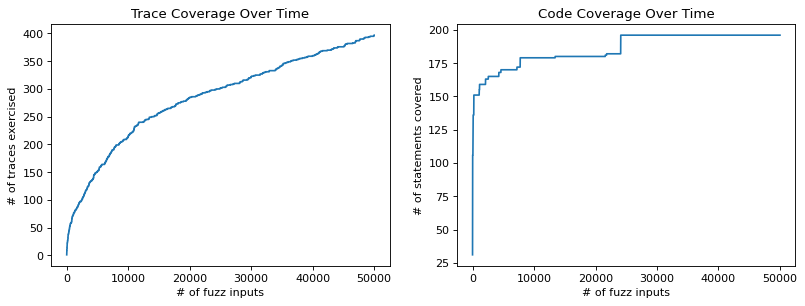

In [67]:
# create random fuzzer
fuzzer = RandomFuzzer(min_length=1, max_length=100,
                      char_start=32, char_range=94)

# create population of fuzz inputs
population = []
for i in range(trials):
    population.append(fuzzer.fuzz())

# execute and measure trace coverage
trace_timeseries = population_trace_coverage(population, my_parser)[1]

# execute and measure code coverage
code_timeseries = population_coverage(population, my_parser)[1]

# plot trace coverage over time
plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.plot(trace_timeseries)
plt.xlabel('# of fuzz inputs')
plt.ylabel('# of traces exercised')
plt.title('Trace Coverage Over Time')

# plot code coverage over time
plt.subplot(1, 2, 2)
plt.plot(code_timeseries)
plt.xlabel('# of fuzz inputs')
plt.ylabel('# of statements covered')
plt.title('Code Coverage Over Time');

Above, we can see trace coverage (left) and code coverage (right) over time. Here are our observations.
1. **Trace coverage is more robust**. There are less sudden jumps in the graph compared to code coverage.
2. **Trace coverage is more fine grained.** There are more traces than statements covered in the end (y-axis).
3. **Trace coverage grows more steadily**. Code coverage exercises more than half the statements it has exercised after 50k inputs with the first input. Instead, the number of traces covered grows slowly and steadily since each input can yield only one execution trace.

It is for this reason that one of the most prominent and successful fuzzers today, american fuzzy lop (AFL), uses a similar *measure of progress* (a hash computed over the branches exercised by the input).

### Evaluating the Discovery Probability Estimate

Let's find out how the Good-Turing estimator performs as estimate of discovery probability when we are fuzzing to discover execution traces rather than trigrams. 

To measure the empirical probability, we execute the same population of inputs (n=50000) and measure in regular intervals (`measurements=100` intervals). During each measurement, we repeat the following experiment `repeats=500` times, reporting the average: If the next input yields a new trace, return 1, otherwise return 0. Note that during these repetitions, we do not record the newly discovered traces as observed.

In [68]:
repeats = 500      # experiment repetitions
measurements = 100  # experiment measurements

In [69]:
emp_timeseries = []
all_coverage = set()
step = int(trials / measurements)

for i in range(0, trials, step):
    if i - step >= 0:
        for j in range(step):
            inp = population[i - j]
            with Coverage() as cov:
                try:
                    my_parser(inp)
                except BaseException:
                    pass
            all_coverage |= set([getTraceHash(cov)])

    discoveries = 0
    for _ in range(repeats):
        inp = fuzzer.fuzz()
        with Coverage() as cov:
            try:
                my_parser(inp)
            except BaseException:
                pass
        if getTraceHash(cov) not in all_coverage:
            discoveries += 1
    emp_timeseries.append(discoveries / repeats)

Now, we compute the Good-Turing estimate over time.

In [70]:
gt_timeseries = []
singleton_timeseries = population_trace_coverage(population, my_parser)[2]
for i in range(1, trials + 1, step):
    gt_timeseries.append(singleton_timeseries[i - 1] / i)

Let's go ahead and plot both time series.

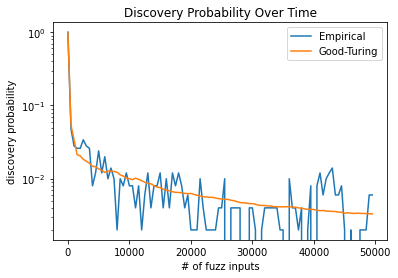

In [71]:
line_emp, = plt.semilogy(emp_timeseries, label="Empirical")
line_gt, = plt.semilogy(gt_timeseries, label="Good-Turing")
plt.legend(handles=[line_emp, line_gt])
plt.xticks(range(0, measurements + 1, int(measurements / 5)),
           range(0, trials + 1, int(trials / 5)))
plt.xlabel('# of fuzz inputs')
plt.ylabel('discovery probability')
plt.title('Discovery Probability Over Time');

Again, the Good-Turing estimate appears to be *highly accurate*. In fact, the empirical estimator has a much lower precision as indicated by the large swings. You can try and increase the number of repetitions (`repeats`) to get more precision for the empirical estimates, however, at the cost of waiting much longer.

### Discovery Probability Quantifies Residual Risk

Alright. You have gotten a hold of a couple of powerful machines and used them to fuzz a software system for several months without finding any vulnerabilities. Is the system vulnerable?

Well, who knows? We cannot say for sure; there is always some residual risk. Testing is not verification. Maybe the next test input that is generated reveals a vulnerability.

Let's say *residual risk* is the probability that the next test input reveals a vulnerability that has not been found, yet. Böhme \cite{Boehme2018stads} has shown that the Good-Turing estimate of the discovery probability is also an estimate of the maximum residual risk.

**Proof sketch (Residual Risk)**. Here is a proof sketch that shows that an estimator of discovery probability for an arbitrary definition of species gives an upper bound on the probability to discover a vulnerability when none has been found: Suppose, for each "old" species A (here, execution trace), we derive two "new" species: Some inputs belonging to A expose a vulnerability while others belonging to A do not. We know that _only_ species that do not expose a vulnerability have been discovered. Hence, _all_ species exposing a vulnerability and _some_ species that do not expose a vulnerability remain undiscovered. Hence, the probability to discover a new species gives an upper bound on the probability to discover (a species that exposes) a vulnerability. **QED**.

An estimate of the discovery probability is useful in many other ways.

1. **Discovery probability**. We can estimate, at any point during the fuzzing campaign, the probability that the next input belongs to a previously unseen species (here, that it yields a new execution trace, i.e., exercises a new set of statements).
2. **Complement of discovery probability**. We can estimate the proportion of *all* inputs the fuzzer can generate for which we have already seen the species (here, execution traces). In some sense, this allows us to quantify the *progress of the fuzzing campaign towards completion*: If the probability to discovery a new species is too low, we might as well abort the campaign.
3. **Inverse of discovery probability**. We can predict the number of test inputs needed, so that we can expect the discovery of a new species (here, execution trace).

## How Do We Know When to Stop Fuzzing?

In fuzzing, we have measures of progress such as [code coverage](Coverage.ipynb) or [grammar coverage](GrammarCoverageFuzzer.ipynb). Suppose, we are interested in covering all statements in the program. The _percentage_ of statements that have already been covered quantifies how "far" we are from completing the fuzzing campaign. However, sometimes we know only the _number_ of species $S(n)$ (here, statements) that have been discovered after generating $n$ fuzz inputs. The percentage $S(n)/S$ can only be computed if we know the _total number_ of species $S$. Even then, not all species may be feasible.

### A Success Estimator

If we do not _know_ the total number of species, then let's at least _estimate_ it: As we have seen before, species discovery slows down over time. In the beginning, many new species are discovered. Later, many inputs need to be generated before discovering the next species. In fact, given enough time, the fuzzing campaign approaches an _asymptote_. It is this asymptote that we can estimate.

In 1984, Anne Chao, a well-known theoretical bio-statistician, has developed an estimator $\hat S$ which estimates the asymptotic total number of species $S$:
\begin{align}
\hat S_\text{Chao1} = \begin{cases}
S(n) + \frac{f_1^2}{2f_2} & \text{if $f_2>0$}\\
S(n) + \frac{f_1(f_1-1)}{2} & \text{otherwise}
\end{cases}
\end{align}
* where $f_1$ and $f_2$ is the number of singleton and doubleton species, respectively (that have been observed exactly once or twice, resp.), and 
* where $S(n)$ is the number of species that have been discovered after generating $n$ fuzz inputs.

So, how does Chao's estimate perform? To investigate this, we generate `trials=400000` fuzz inputs using a fuzzer setting that allows us to see an asymptote in a few seconds: We measure trace coverage. After half-way into our fuzzing campaign (`trials`/2=100000), we generate Chao's estimate $\hat S$ of the asymptotic total number of species. Then, we run the remainer of the campaign to see the "empirical" asymptote.

In [72]:
trials = 400000
fuzzer = RandomFuzzer(min_length=2, max_length=4,
                      char_start=32, char_range=32)
population = []
for i in range(trials):
    population.append(fuzzer.fuzz())

_, trace_ts, f1_ts, f2_ts = population_trace_coverage(population, my_parser)

In [73]:
time = int(trials / 2)
time

200000

In [74]:
f1 = f1_ts[time]
f2 = f2_ts[time]
Sn = trace_ts[time]
if f2 > 0:
    hat_S = Sn + f1 * f1 / (2 * f2)
else:
    hat_S = Sn + f1 * (f1 - 1) / 2

After executing `time` fuzz inputs (half of all), we have covered this many traces:

In [75]:
time

200000

In [76]:
Sn

66

We can estimate there are this many traces in total:

In [77]:
hat_S

71.04166666666667

Hence, we have achieved this percentage of the estimate:

In [78]:
100 * Sn / hat_S

92.9032258064516

After executing `trials` fuzz inputs, we have covered this many traces:

In [79]:
trials

400000

In [80]:
trace_ts[trials - 1]

72

The accuracy of Chao's estimator is quite reasonable. It isn't always accurate -- particularly at the beginning of a fuzzing campaign when the [discovery probability](WhenIsEnough.ipynb#Measuring-Trace-Coverage-over-Time) is still very high. Nevertheless, it demonstrates the main benefit of reporting a percentage to assess the progress of a fuzzing campaign towards completion.

***Try it***. *Try setting `trials` to 1 million and `time` to `int(trials / 4)`.*

### Extrapolating Fuzzing Success
<!--  ## Cost-Benefit Analysis: Extrapolating the Number of Species Discovered -->

Suppose you have run the fuzzer for a week, which generated $n$ fuzz inputs and discovered $S(n)$ species (here, covered $S(n)$ execution traces). Instead, of running the fuzzer for another week, you would like to *predict* how many more species you would discover. In 2003, Anne Chao and her team developed an extrapolation methodology to do just that. We are interested in the number $S(n+m^*)$ of species discovered if $m^*$ more fuzz inputs were generated:

\begin{align}
\hat S(n + m^*) = S(n) + \hat f_0 \left[1-\left(1-\frac{f_1}{n\hat f_0 + f_1}\right)^{m^*}\right]
\end{align}
* where $\hat f_0=\hat S - S(n)$ is an estimate of the number $f_0$ of undiscovered species, and 
* where $f_1$ is the number of singleton species, i.e., those we have observed exactly once. 

The number $f_1$ of singletons, we can just keep track of during the fuzzing campaign itself. The estimate of the number $\hat f_0$ of undiscovered species, we can simply derive using Chao's estimate $\hat S$ and the number of observed species $S(n)$.

Let's see how Chao's extrapolator performs by comparing the predicted number of species to the empirical number of species.

In [81]:
prediction_ts = [None] * time
f0 = hat_S - Sn

for m in range(trials - time):
    assert (time * f0 + f1) != 0 , 'time:%s f0:%s f1:%s' % (time, f0,f1)
    prediction_ts.append(Sn + f0 * (1 - (1 - f1 / (time * f0 + f1)) ** m))

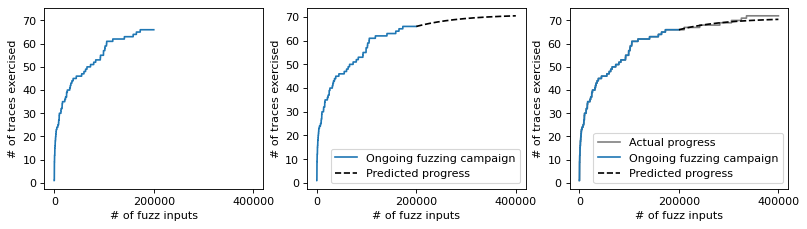

In [82]:
plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
plt.plot(trace_ts, color='white')
plt.plot(trace_ts[:time])
plt.xticks(range(0, trials + 1, int(time)))
plt.xlabel('# of fuzz inputs')
plt.ylabel('# of traces exercised')

plt.subplot(1, 3, 2)
line_cur, = plt.plot(trace_ts[:time], label="Ongoing fuzzing campaign")
line_pred, = plt.plot(prediction_ts, linestyle='--',
                      color='black', label="Predicted progress")
plt.legend(handles=[line_cur, line_pred])
plt.xticks(range(0, trials + 1, int(time)))
plt.xlabel('# of fuzz inputs')
plt.ylabel('# of traces exercised')

plt.subplot(1, 3, 3)
line_emp, = plt.plot(trace_ts, color='grey', label="Actual progress")
line_cur, = plt.plot(trace_ts[:time], label="Ongoing fuzzing campaign")
line_pred, = plt.plot(prediction_ts, linestyle='--',
                      color='black', label="Predicted progress")
plt.legend(handles=[line_emp, line_cur, line_pred])
plt.xticks(range(0, trials + 1, int(time)))
plt.xlabel('# of fuzz inputs')
plt.ylabel('# of traces exercised');

The prediction from Chao's extrapolator looks quite accurate. We make a prediction at `time=trials/4`. Despite an extrapolation by 3 times (i.e., at trials), we can see that the predicted value (black, dashed line) closely matches the empirical value (grey, solid line).

***Try it***. Again, try setting `trials` to 1 million and `time` to `int(trials / 4)`.

## Lessons Learned

* One can measure the _progress_ of a fuzzing campaign (as species over time, i.e., $S(n)$).
* One can measure the _effectiveness_ of a fuzzing campaign (as asymptotic total number of species $S$).
* One can estimate the _effectiveness_ of a fuzzing campaign using the Chao1-estimator $\hat S$.
* One can extrapolate the _progress_ of a fuzzing campaign, $\hat S(n+m^*)$.
* One can estimate the _residual risk_ (i.e., the probability that a bug exists that has not been found) using the Good-Turing estimator $GT$ of the species discovery probability.

## Next Steps

This chapter is the last in the book!  If you want to continue reading, have a look at the [Appendices](99_Appendices.ipynb).  Otherwise, _make use of what you have learned and go and create great fuzzers and test generators!_

## Background

* A **statistical framework for fuzzing**, inspired from ecology. Marcel Böhme. [STADS: Software Testing as Species Discovery](https://mboehme.github.io/paper/TOSEM18.pdf). ACM TOSEM 27(2):1--52
* Estimating the **discovery probability**: I.J. Good. 1953. [The population frequencies of species and the
estimation of population parameters](https://www.jstor.org/stable/2333344). Biometrika 40:237–264.
* Estimating the **asymptotic total number of species** when each input can belong to exactly one species: Anne Chao. 1984. [Nonparametric estimation of the number of classes in a population](https://www.jstor.org/stable/4615964). Scandinavian Journal of Statistics 11:265–270
* Estimating the **asymptotic total number of species** when each input can belong to one or more species: Anne Chao. 1987. [Estimating the population size for capture-recapture data with unequal catchability](https://www.jstor.org/stable/2531532). Biometrics 43:783–791
* **Extrapolating** the number of discovered species: Tsung-Jen Shen, Anne Chao, and Chih-Feng Lin. 2003. [Predicting the Number of New Species in Further Taxonomic Sampling](http://chao.stat.nthu.edu.tw/wordpress/paper/2003_Ecology_84_P798.pdf). Ecology 84, 3 (2003), 798–804.

## Exercises
I.J. Good and Alan Turing developed an estimator for the case where each input belongs to exactly one species. For instance, each input yields exactly one execution trace (see function [`getTraceHash`](#Trace-Coverage)). However, this is not true in general. For instance, each input exercises multiple statements and branches in the source code. Generally, each input can belong to one *or more* species. 

In this extended model, the underlying statistics are quite different. Yet, all estimators that we have discussed in this chapter turn out to be almost identical to those for the simple, single-species model. For instance, the Good-Turing estimator $C$ is defined as 
$$C=\frac{Q_1}{n}$$ 
where $Q_1$ is the number of singleton species and $n$ is the number of generated test cases.
Throughout the fuzzing campaign, we record for each species the *incidence frequency*, i.e., the number of inputs that belong to that species. Again, we define a species $i$ as *singleton species* if we have seen exactly one input that belongs to species $i$.

### Exercise 1: Estimate and Evaluate the Discovery Probability for Statement Coverage

In this exercise, we create a Good-Turing estimator for the simple fuzzer.

#### Part 1: Population Coverage

Implement a function `population_stmt_coverage()` as in [the section on estimating discovery probability](#Estimating-the-Discovery-Probability) that monitors the number of singletons and doubletons over time, i.e., as the number $i$ of test inputs increases.

In [83]:
from Coverage import population_coverage, Coverage
...

**Solution.** Here we go:

In [84]:
def population_stmt_coverage(population, function):
    cumulative_coverage = []
    all_coverage = set()
    cumulative_singletons = []
    cumulative_doubletons = []
    singletons = set()
    doubletons = set()

    for s in population:
        with Coverage() as cov:
            try:
                function(s)
            except BaseException:
                pass
        cur_coverage = cov.coverage()

        # singletons and doubletons
        doubletons -= cur_coverage
        doubletons |= singletons & cur_coverage
        singletons -= cur_coverage
        singletons |= cur_coverage - (cur_coverage & all_coverage)
        cumulative_singletons.append(len(singletons))
        cumulative_doubletons.append(len(doubletons))

        # all and cumulative coverage
        all_coverage |= cur_coverage
        cumulative_coverage.append(len(all_coverage))

    return all_coverage, cumulative_coverage, cumulative_singletons, cumulative_doubletons

#### Part 2: Population

Use the random `fuzzer(min_length=1, max_length=1000, char_start=0, char_range=255)` from [the chapter on Fuzzers](Fuzzer.ipynb) to generate a population of $n=10000$ fuzz inputs.

In [85]:
from Fuzzer import RandomFuzzer
from html.parser import HTMLParser
...

Ellipsis

**Solution.**  This is fairly straightforward:

In [86]:
trials = 2000  # increase to 10000 for better convergences. Will take a while..

We create a wrapper function...

In [87]:
def my_parser(inp):
    parser = HTMLParser()  # resets the HTMLParser object for every fuzz input
    parser.feed(inp)

... and a random fuzzer:

In [88]:
fuzzer = RandomFuzzer(min_length=1, max_length=1000,
                      char_start=0, char_range=255)

We fill the population:

In [89]:
population = []
for i in range(trials):
    population.append(fuzzer.fuzz())

#### Part 3: Estimating Probabilities

Execute the generated inputs on the Python HTML parser (`from html.parser import HTMLParser`) and estimate the probability that the next input covers a previously uncovered statement (i.e., the discovery probability) using the Good-Turing estimator.

**Solution.** Here we go:

In [90]:
measurements = 100  # experiment measurements
step = int(trials / measurements)

gt_timeseries = []
singleton_timeseries = population_stmt_coverage(population, my_parser)[2]
for i in range(1, trials + 1, step):
    gt_timeseries.append(singleton_timeseries[i - 1] / i)

#### Part 4: Empirical Evaluation

Empirically evaluate the accuracy of the Good-Turing estimator (using $10000$ repetitions) of the probability to cover new statements using the experimental procedure at the end of [the section on estimating discovery probability](#Estimating-the-Discovery-Probability).

**Solution.** This is as above:

In [91]:
# increase to 10000 for better precision (less variance). Will take a while..
repeats = 100

In [92]:
emp_timeseries = []
all_coverage = set()
for i in range(0, trials, step):
    if i - step >= 0:
        for j in range(step):
            inp = population[i - j]
            with Coverage() as cov:
                try:
                    my_parser(inp)
                except BaseException:
                    pass
            all_coverage |= cov.coverage()

    discoveries = 0
    for _ in range(repeats):
        inp = fuzzer.fuzz()
        with Coverage() as cov:
            try:
                my_parser(inp)
            except BaseException:
                pass
        # If intersection not empty, a new stmt was (dis)covered
        if cov.coverage() - all_coverage:
            discoveries += 1
    emp_timeseries.append(discoveries / repeats)

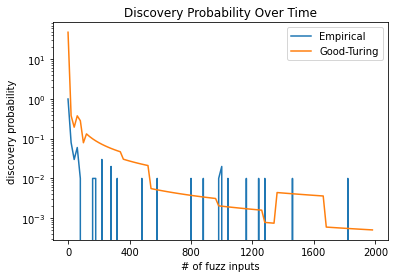

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
line_emp, = plt.semilogy(emp_timeseries, label="Empirical")
line_gt, = plt.semilogy(gt_timeseries, label="Good-Turing")
plt.legend(handles=[line_emp, line_gt])
plt.xticks(range(0, measurements + 1, int(measurements / 5)),
           range(0, trials + 1, int(trials / 5)))
plt.xlabel('# of fuzz inputs')
plt.ylabel('discovery probability')
plt.title('Discovery Probability Over Time');

### Exercise 2: Extrapolate and Evaluate Statement Coverage

In this exercise, we use Chao's extrapolation method to estimate the success of fuzzing.

#### Part 1: Create Population

Use the random `fuzzer(min_length=1, max_length=1000, char_start=0, char_range=255)` to generate a population of $n=400000$ fuzz inputs.

**Solution.** Here we go:

In [94]:
trials = 400  # Use 400000 for actual solution.  This takes a while!

In [95]:
population = []
for i in range(trials):
    population.append(fuzzer.fuzz())

_, stmt_ts, Q1_ts, Q2_ts = population_stmt_coverage(population, my_parser)

#### Part 2: Compute Estimate

Compute an estimate of the total number of statements $\hat S$ after $n/4=100000$ fuzz inputs were generated. In the extended model, $\hat S$ is computed as
\begin{align}
\hat S_\text{Chao1} = \begin{cases}
S(n) + \frac{Q_1^2}{2Q_2} & \text{if $Q_2>0$}\\
S(n) + \frac{Q_1(Q_1-1)}{2} & \text{otherwise}
\end{cases}
\end{align}
  * where $Q_1$ and $Q_2$ is the number of singleton and doubleton statements, respectively (i.e., statements that have been exercised by exactly one or two fuzz inputs, resp.), and 
  * where $S(n)$ is the number of statements that have been (dis)covered after generating $n$ fuzz inputs.

**Solution.** Here we go:

In [96]:
time = int(trials / 4)
Q1 = Q1_ts[time]
Q2 = Q2_ts[time]
Sn = stmt_ts[time]

if Q2 > 0:
    hat_S = Sn + Q1 * Q1 / (2 * Q2)
else:
    hat_S = Sn + Q1 * (Q1 - 1) / 2

print("After executing %d fuzz inputs, we have covered %d **(%.1f %%)** statements.\n" % (time, Sn, 100 * Sn / hat_S) +
      "After executing %d fuzz inputs, we estimate there are %d statements in total.\n" % (time, hat_S) +
      "After executing %d fuzz inputs, we have covered %d statements." % (trials, stmt_ts[trials - 1]))

After executing 100 fuzz inputs, we have covered 132 **(100.0 %)** statements.
After executing 100 fuzz inputs, we estimate there are 132 statements in total.
After executing 400 fuzz inputs, we have covered 155 statements.


#### Part 3: Compute and Evaluate Extrapolator

Compute and evaluate Chao's extrapolator by comparing the predicted number of statements to the empirical number of statements.

**Solution.** Here's our solution:

In [97]:
prediction_ts = [None] * time
Q0 = hat_S - Sn

for m in range(trials - time):
    prediction_ts.append(Sn + Q0 * (1 - (1 - Q1 / (time * Q0 + Q1)) ** m))

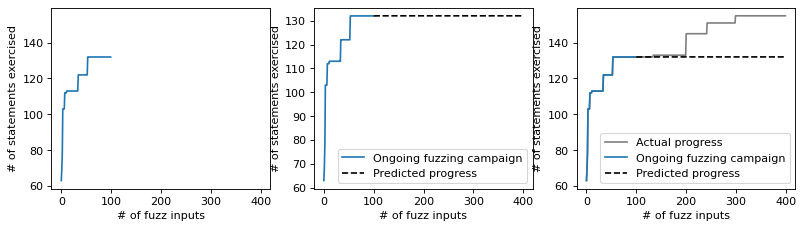

In [98]:
plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
plt.plot(stmt_ts, color='white')
plt.plot(stmt_ts[:time])
plt.xticks(range(0, trials + 1, int(time)))
plt.xlabel('# of fuzz inputs')
plt.ylabel('# of statements exercised')

plt.subplot(1, 3, 2)
line_cur, = plt.plot(stmt_ts[:time], label="Ongoing fuzzing campaign")
line_pred, = plt.plot(prediction_ts, linestyle='--',
                      color='black', label="Predicted progress")
plt.legend(handles=[line_cur, line_pred])
plt.xticks(range(0, trials + 1, int(time)))
plt.xlabel('# of fuzz inputs')
plt.ylabel('# of statements exercised')

plt.subplot(1, 3, 3)
line_emp, = plt.plot(stmt_ts, color='grey', label="Actual progress")
line_cur, = plt.plot(stmt_ts[:time], label="Ongoing fuzzing campaign")
line_pred, = plt.plot(prediction_ts, linestyle='--',
                      color='black', label="Predicted progress")
plt.legend(handles=[line_emp, line_cur, line_pred])
plt.xticks(range(0, trials + 1, int(time)))
plt.xlabel('# of fuzz inputs')
plt.ylabel('# of statements exercised');